## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [304]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.sparse
import scipy.sparse.linalg
import numpy as np

import utils

## Part 1 Toy Problem (20 pts)

In [305]:
def toy_reconstruct(source_image: np.ndarray) -> np.ndarray:
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a 
    mistake, so let's start with a toy example. Reconstruct this image from its gradient values, 
    plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the 
    value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more 
    objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """

    rows, columns = source_image.shape

    # Count equations: one for each horizontal pair + one for each vertical pair + one anchor
    number_of_equations = rows * (columns - 1) + (rows - 1) * columns + 1

    coefficient_matrix = scipy.sparse.lil_matrix(
        (number_of_equations, rows * columns), dtype="float64"
    )
    solutions_matrix = np.zeros((number_of_equations, 1), dtype="float64")

    def linear_index(y: int, x: int) -> int:
        """Map 2D coordinates (y, x) to a 1D linear index."""
        return y * columns + x

    equation_row = 0

    # Horizontal gradient constraints: v(x+1, y) - v(x, y) = s(x+1, y) - s(x, y)
    for y in range(rows):
        for x in range(columns - 1):
            left_index = linear_index(y, x)
            right_index = linear_index(y, x + 1)

            coefficient_matrix[equation_row, right_index] = 1.0
            coefficient_matrix[equation_row, left_index] = -1.0
            solutions_matrix[equation_row, 0] = source_image[y, x + 1] - source_image[y, x]
            equation_row += 1

    # Vertical gradient constraints: v(x, y+1) - v(x, y) = s(x, y+1) - s(x, y)
    for y in range(rows - 1):
        for x in range(columns):
            top_index = linear_index(y, x)
            bottom_index = linear_index(y + 1, x)

            coefficient_matrix[equation_row, bottom_index] = 1.0
            coefficient_matrix[equation_row, top_index] = -1.0
            solutions_matrix[equation_row, 0] = source_image[y + 1, x] - source_image[y, x]
            equation_row += 1

    # Intensity anchor: v(0, 0) = s(0, 0)
    coefficient_matrix[equation_row, linear_index(0, 0)] = 1.0
    solutions_matrix[equation_row, 0] = source_image[0, 0]

    # Solve least squares
    output = scipy.sparse.linalg.lsqr(
        coefficient_matrix.tocsr(),
        solutions_matrix[:, 0],
        atol=1e-7,
        btol=1e-7,
    )[0]

    reconstructed_image = output.reshape((rows, columns))

    return reconstructed_image


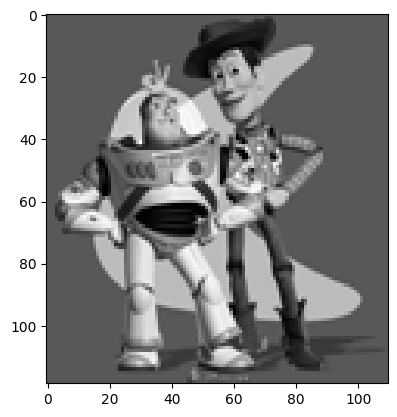

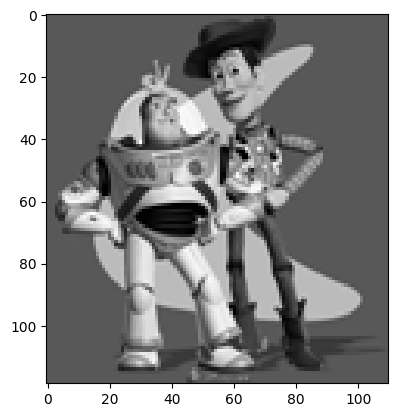

Max error is:  6.733238188977309e-05


In [306]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

In [307]:
BACKGROUNDS = [
    "samples/im2.JPG",
    "my_images/floor.jpg",
    "my_images/colorado.jpg",
    "my_images/carpet_half.jpg",
]

FOREGROUNDS = [
    "samples/penguin-chick.jpeg",
    "my_images/malachai_resized.png",
    "my_images/copter.png",
    "my_images/croc.png",
]

BACKGROUND_IMAGE = BACKGROUNDS[3]
FOREGROUND_IMAGE = FOREGROUNDS[3]

FOREGROUND_POINTS = {
    "samples/penguin-chick.jpeg": (
        [(65, 24), (359, 24), (359, 457), (65, 457)],
        (500, 2500),
    ),
    "my_images/malachai_resized.png": (
        # [(189, 23), (843, 20), (843, 1311), (189, 1311)], 
        [(304, 25), (505, 256), (760, 39), (846, 496), (736, 607), (798, 889), (834, 1114), (763, 1155), (723, 970), (625, 1069), (615, 1294), (568, 1303), (520, 1248), (523, 1137), (457, 1149), (445, 1275), (366, 1281), (358, 1084), (288, 996), (226, 1068), (190, 996), (253, 873)],
        (1300, 2500)
    ),
    "my_images/copter.png": (
        # [(1, 1), (500, 1), (500, 333), (1, 333)],
        [(27, 176), (354, 22), (382, 33), (215, 120), (304, 163), (456, 127), (476, 232), (285, 231), (232, 276), (117, 271)],
        (750, 1200)
    ),
    "my_images/croc.png": (
        # Rectangle:
        # [(70, 101), (734, 101), (734, 364), (70, 364)], 
        # For poisson:
        [(82, 138), (167, 100), (490, 160), (606, 215), (731, 351), (335, 364), (164, 342), (77, 230)],
        # For laplacian?
        # []
        (1050, 800)
    ),
    "my_images/": ([], ()),
}

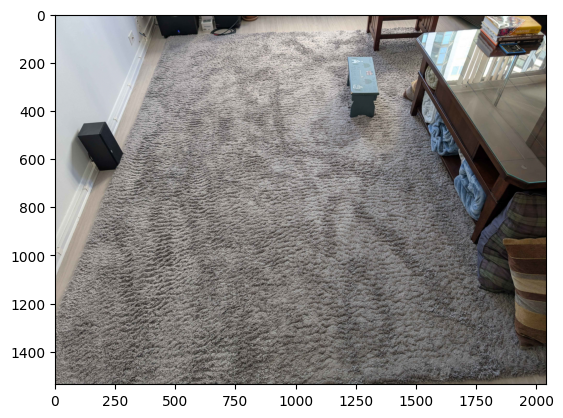

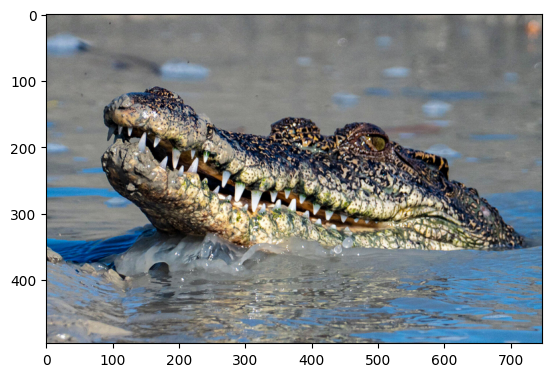

8


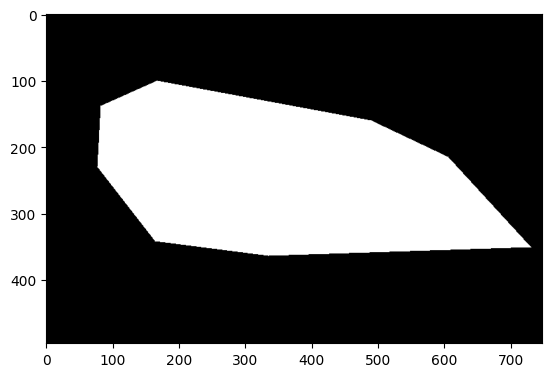

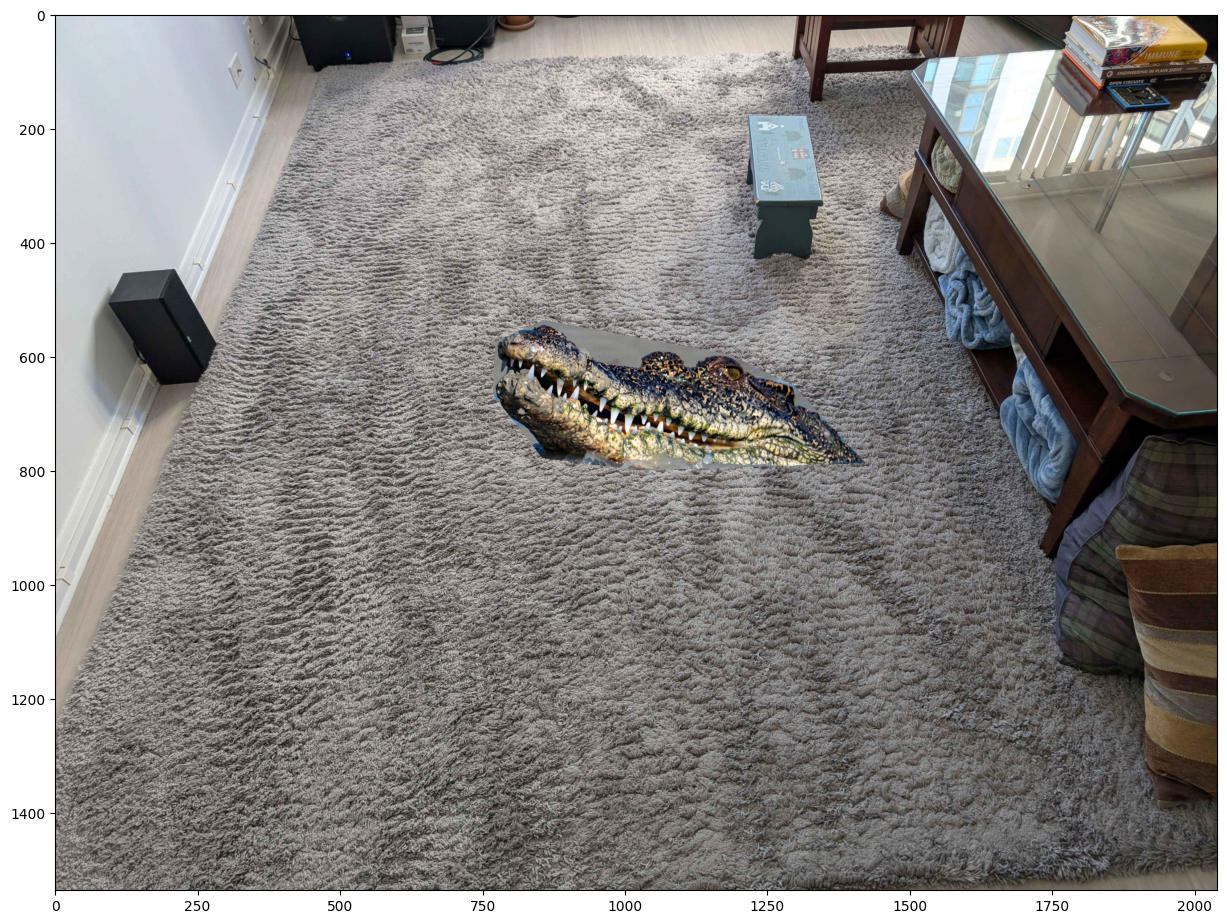

In [308]:
background_img = cv2.cvtColor(cv2.imread(BACKGROUND_IMAGE), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread(FOREGROUND_IMAGE), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

# xs = (65, 359, 359, 65)
# ys = (24, 24, 457, 457)
bounding_box, bottom_center = FOREGROUND_POINTS[FOREGROUND_IMAGE]
print(len(bounding_box))
xs, ys = zip(*bounding_box)
object_mask = utils.get_mask(ys, xs, object_img)
# bottom_center = (500, 2500) # (x,y)

object_img, object_mask = utils.crop_object_img(object_img, object_mask)
position = utils.upper_left_background_rc(object_mask, bottom_center)
plt.figure(figsize=(15,15))
plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, position))



## Part 2 Poisson Blending (50 pts)

In [309]:
def poisson_blend(object_img, object_mask, bg_img, position, mixed_gradients: bool = False):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    object_mask = object_mask.astype(bool)
    if object_img.ndim == 2:
        object_img = object_img[..., None]
    if bg_img.ndim == 2:
        bg_img = bg_img[..., None]

    object_height, object_width, number_of_channels = object_img.shape
    *_, bg_channels = bg_img.shape

    object_patch = object_img[0:object_height, 0:object_width, :]
    mask_patch = object_mask[0:object_height, 0:object_width]
    background_patch = bg_img[
        position[0]:position[0] + object_height, 
        position[1]:position[1] + object_width, 
        :
    ].copy()

    patch_height, patch_width = mask_patch.shape

    # im2var code from the hints doc
    number_of_variables = mask_patch.sum()
    im2var = -np.ones((patch_height, patch_width), dtype=np.int64)
    im2var[mask_patch] = np.arange(number_of_variables)

    # If neighbor is inside the mask:      v_i - v_j = s_i - s_j
    # If neighbor is outside the mask:     v_i       = s_i - s_j + t_j
    # One equation per masked pixel per valid neighbor (up, down, left, right).
    neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Count equations to preallocate (each masked pixel contributes up to 4 equations)
    number_of_equations = 0
    for row in range(patch_height):
        for col in range(patch_width):
            if not mask_patch[row, col]:
                continue
            for dy, dx in neighbor_offsets:
                if 0 <= row + dy < patch_height and 0 <= col + dx < patch_width:
                    number_of_equations += 1

    # Solve channel by channel
    for channel_index in range(number_of_channels):
        # Convert to float64 for numerical stability
        source_patch = object_patch[..., channel_index]
        target_patch = background_patch[..., channel_index]

        coefficient_matrix = scipy.sparse.lil_matrix(
            (number_of_equations, number_of_variables), dtype="float64"
        )
        right_hand_side = np.zeros((number_of_equations,), dtype="float64")

        equation_row = 0
        for row in range(patch_height):
            for col in range(patch_width):
                if not mask_patch[row, col]:
                    continue

                variable_index_center = im2var[row, col]
                s_center = source_patch[row, col]

                for dy, dx in neighbor_offsets:
                    ny, nx = row + dy, col + dx
                    if not (0 <= ny < patch_height and 0 <= nx < patch_width):
                        # Neighbor outside the overlapping patch... skip
                        continue

                    s_neighbor = source_patch[ny, nx]

                    coefficient_matrix[equation_row, variable_index_center] = 1.0

                    # TODO: Take the mixed gradients calcs out of the branch so they are not repeated
                    if mask_patch[ny, nx]:
                        # Neighbor is also unknown: v_center - v_neighbor = s_center - s_neighbor
                        variable_index_neighbor = im2var[ny, nx]
                        coefficient_matrix[equation_row, variable_index_neighbor] = -1.0

                        # right_hand_side[equation_row] = s_center - s_neighbor
                        source_gradient = s_center - s_neighbor
                        target_gradient = target_patch[row, col] - target_patch[ny, nx]
                        if mixed_gradients:
                            gradient_guide = (
                                target_gradient 
                                if abs(target_gradient) > abs(source_gradient) 
                                else source_gradient
                            )
                        else:
                            gradient_guide = source_gradient

                        right_hand_side[equation_row] = gradient_guide

                    else:
                        # Neighbor is fixed to background: v_center = s_center - s_neighbor + t_neighbor
                        t_neighbor = target_patch[ny, nx]
                        # right_hand_side[equation_row] = (s_center - s_neighbor) + t_neighbor

                        source_gradient = s_center - s_neighbor
                        target_gradient = target_patch[row, col] - target_patch[ny, nx]
                        if mixed_gradients:
                            gradient_guide = (
                                target_gradient 
                                if abs(target_gradient) > abs(source_gradient) 
                                else source_gradient
                            )
                        else:
                            gradient_guide = source_gradient

                        right_hand_side[equation_row] = gradient_guide + t_neighbor
                        
                    equation_row += 1

        # Solve least squares
        solution_values = scipy.sparse.linalg.lsqr(
            coefficient_matrix.tocsr(),
            right_hand_side,
            atol=1e-6,
            btol=1e-6,
        )[0]

        # Write the solved values back into the background patch
        reconstructed_channel = target_patch.copy()
        for row in range(patch_height):
            for col in range(patch_width):
                if mask_patch[row, col]:
                    reconstructed_channel[row, col] = solution_values[im2var[row, col]]

        reconstructed_channel = np.clip(reconstructed_channel, 0.0, 1.0)
        background_patch[..., channel_index] = reconstructed_channel

    blended_result = bg_img.copy()
    blended_result[
        position[0]:position[0] + object_height,
        position[1]:position[1] + object_width, 
        :
    ] = background_patch

    return blended_result


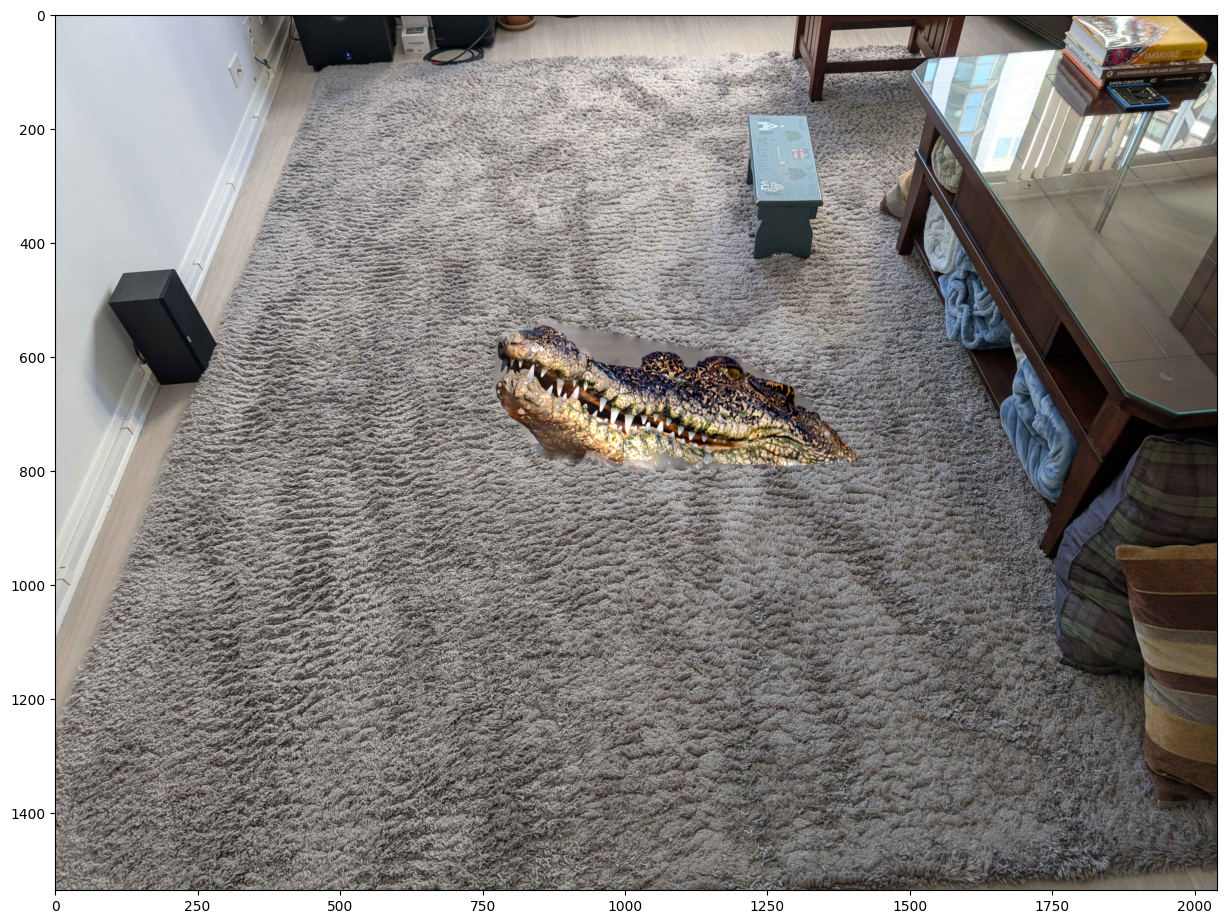

In [310]:
im_blend = np.zeros(background_img.shape)
# for b in np.arange(3):
im_blend = poisson_blend(object_img, object_mask, background_img.copy(), position)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [311]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    # Just pass through to the other function so we're not repeating a ton of logic
    return poisson_blend(
        object_img=object_img,
        object_mask=object_mask,
        bg_img=bg_img,
        position=bg_ul,
        mixed_gradients=True,
    )

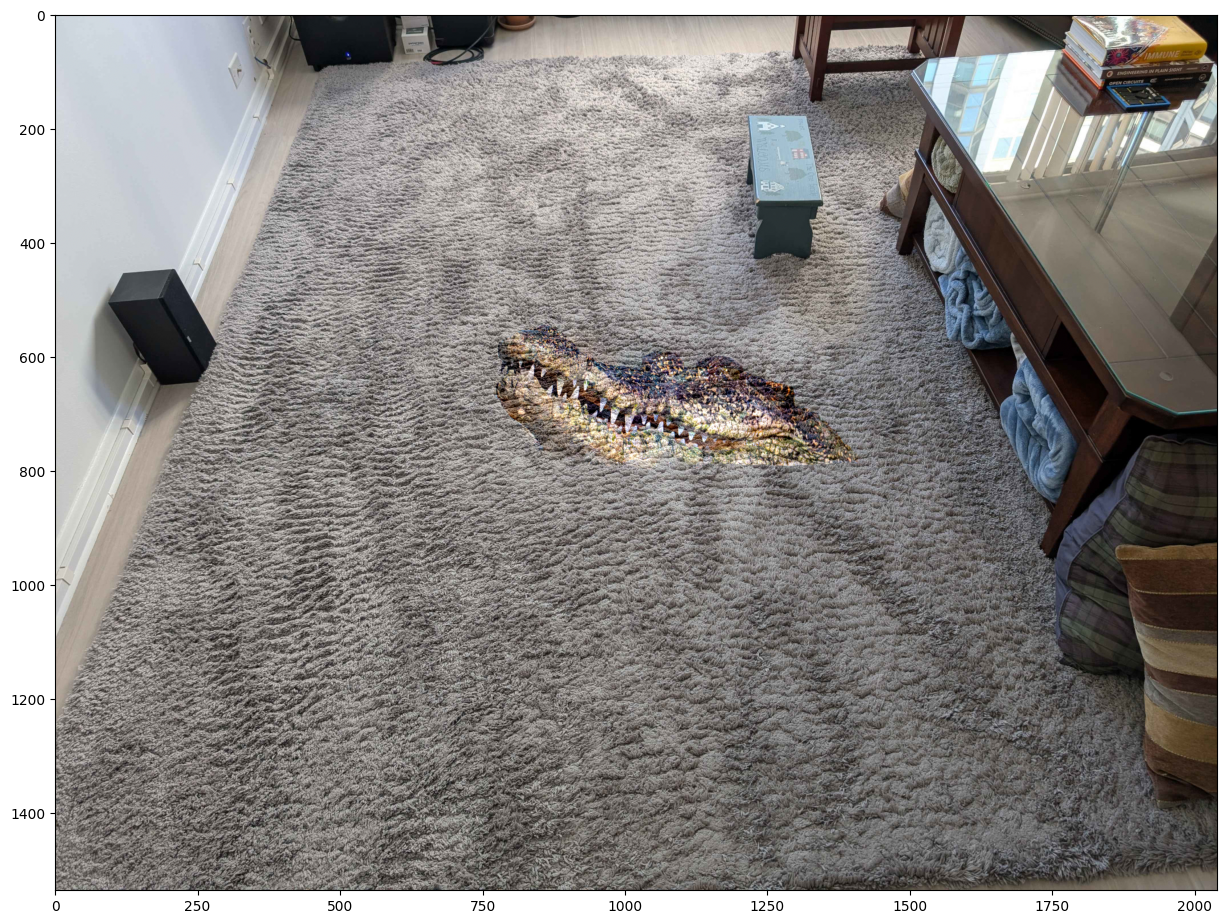

In [312]:
im_mix = np.zeros(background_img.shape)
# for b in np.arange(3):
im_mix = mixed_blend(object_img, object_mask, background_img.copy(), position)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [313]:
def color2gray(color_image: np.ndarray) -> np.ndarray:
    """Create a grayscale image preserving the strongest RGB gradients via Poisson reconstruction.

    Args:
        color_image: HxWx3 float64 image with values in [0, 1].

    Returns:
        HxWx3 float64 grayscale image (broadcast across channels).
    """
    if color_image.ndim != 3 or color_image.shape[2] != 3:
        raise ValueError("Input must be an HxWx3 RGB image.")
    color_image = color_image.astype(np.float64, copy=False)

    rows, cols, _ = color_image.shape

    # Find the strongest gradients
    horizontal_gradients = []
    vertical_gradients = []
    for i in range(3):
        horizontal_gradients.append(color_image[:, 1:, i] - color_image[:, :-1, i])
        vertical_gradients.append(color_image[1:, :, i] - color_image[:-1, :, i])

    horizontal_stack = np.stack(horizontal_gradients, axis=0)
    vertical_stack = np.stack(vertical_gradients, axis=0)

    # Pick channel with largest gradient
    horizontal_index = np.argmax(np.abs(horizontal_stack), axis=0)
    vertical_index = np.argmax(np.abs(vertical_stack), axis=0)

    horizontal = np.take_along_axis(horizontal_stack, horizontal_index[None, ...], axis=0)[0]
    vertical = np.take_along_axis(vertical_stack, vertical_index[None, ...], axis=0)[0]

    # Poisson system
    number_of_equations = rows * (cols - 1) + (rows - 1) * cols + 1
    number_of_variables = rows * cols

    coefficient_matrix = scipy.sparse.lil_matrix((number_of_equations, number_of_variables), dtype="float64")
    solutions_matrix = np.zeros((number_of_equations,), dtype="float64")

    def index_2d_to_1d(y: int, x: int) -> int:
        return y * cols + x

    equation = 0
    # Horizontal
    for y in range(rows):
        for x in range(cols - 1):
            coefficient_matrix[equation, index_2d_to_1d(y, x + 1)] = 1.0
            coefficient_matrix[equation, index_2d_to_1d(y, x)] = -1.0
            solutions_matrix[equation] = horizontal[y, x]
            equation += 1

    # Vertical
    for y in range(rows - 1):
        for x in range(cols):
            coefficient_matrix[equation, index_2d_to_1d(y + 1, x)] = 1.0
            coefficient_matrix[equation, index_2d_to_1d(y, x)] = -1.0
            solutions_matrix[equation] = vertical[y, x]
            equation += 1

    # Anchor at (0,0) w/ intensity equal to mean of original RGB
    anchor_value = float(color_image[0, 0, :].mean())
    coefficient_matrix[equation, index_2d_to_1d(0, 0)] = 1.0
    solutions_matrix[equation] = anchor_value

    result = scipy.sparse.linalg.lsqr(
        coefficient_matrix.tocsr(), solutions_matrix, atol=1e-6, btol=1e-6)[0]
    output = result.reshape((rows, cols))
    output = np.clip(output, 0.0, 1.0)

    # Broadcast to RGB to create a 3channel grayscale
    output_rgb = np.repeat(output[..., None], 3, axis=2)
    return output_rgb


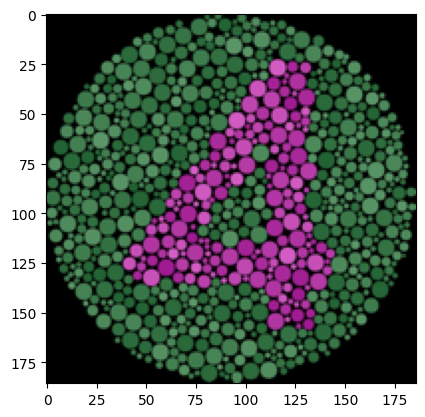

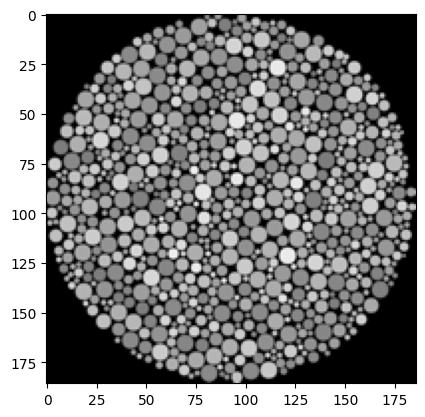

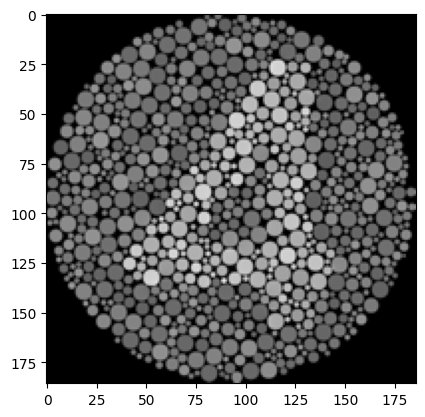

In [314]:
colorblind_image = cv2.imread('samples/colorBlind4.png')
# colorblind_image = cv2.imread('my_images/croton_small.jpg')
plt.imshow(cv2.cvtColor(colorblind_image, cv2.COLOR_BGR2RGB))
plt.show()

colorblind_image_gray = cv2.cvtColor(colorblind_image.copy(), cv2.COLOR_BGR2GRAY)
plt.imshow(colorblind_image_gray, cmap="gray")
plt.show()

colorblind_image = colorblind_image.astype('double') / 255.0

output = color2gray(colorblind_image)
plt.imshow(output)
plt.show()

## Laplacian pyramid blending (20 pts)

## More gradient domain processing (up to 20 pts)